In [1]:
from keras.layers import Input, Reshape, Flatten, Activation
from keras.layers.merge import _Merge
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.models import load_model
from keras.utils import multi_gpu_model

import keras
import tensorflow as tf
import keras.backend as K
import keras.backend.tensorflow_backend as KTF

import shutil, os, sys, io, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
from functools import partial
from tqdm import tqdm

os.chdir('/home/k_yonhon/py/Keras-GAN/pggan/')
sys.path.append(os.pardir)

from tensor_board_logger import TensorBoardLogger
from layer_visualizer import LayerVisualizer

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
KTF.set_session(session)

gpu_count = 0
batch_size = 32

In [2]:
class RandomWeightedAverage(_Merge):
    """Takes a randomly-weighted average of two tensors. In geometric terms, this
    outputs a random point on the line between each pair of input points.
    Inheriting from _Merge is a little messy but it was the quickest solution I could
    think of. Improvements appreciated."""

    def _merge_function(self, inputs):
        weights = K.random_uniform((batch_size, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])

def compute_gradients(tensor, var_list):
    grads = tf.gradients(tensor, var_list) # return A list of sum(dy/dx) for each x in xs.
    return [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(var_list, grads)]

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def gradient_penalty_loss(y_true, y_pred, averaged_samples,
                          gradient_penalty_weight):
    gradients = compute_gradients(y_pred, [averaged_samples])[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)

In [3]:
class WGANGP():
    def __init__(self):
        # ---------------------
        #  for log on TensorBoard
        # ---------------------
        target_dir = "./my_log_dir"
        shutil.rmtree(target_dir, ignore_errors=True)
        os.mkdir(target_dir)
        self.logger = TensorBoardLogger(log_dir=target_dir)

        # ---------------------
        #  Parameter
        # ---------------------
        self.resume = 0
        
        self.n_critic = 5
        self.λ = 10
        
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.input_rows = 4
        self.input_cols = 4
        self.latent_dim = 128  # Noiseの次元
        optimizer = Adam(lr=0.00005, beta_1=0., beta_2=0.9, epsilon=None, decay=0.0, amsgrad=False)
        # optimizer = Adam(lr=0.00005, beta_1=0., beta_2=0.9, epsilon=None, decay=0.0, amsgrad=False)
        # optimizer = Adam(0.00001, beta_1=0.5, beta_2=0.9)

        # ---------------------
        #  Build model
        # ---------------------
        with tf.device("/cpu:0"):
            if self.resume == 0:
                self.critic = self.build_critic()
                self.generator = self.build_generator()
            else:
                self.critic = load_model('./saved_model/wgangp32_disc_model_'+str(self.resume)+'epoch.h5')
                self.generator = load_model('./saved_model/wgangp32_gen_model_'+str(self.resume)+'epoch.h5')
                
            #  Load pretrained weights
            pre_gen = load_model('./saved_model/wgangp16_gen_model.h5')
            for i, layer in enumerate(self.generator.layers[1].layers):
                if i in [i for i in range(1, int(math.log(self.img_rows / self.input_rows, 2)) * 2, 2)]:
                    layer.set_weights(pre_gen.layers[1].layers[i].get_weights())

            pre_critic = load_model('./saved_model/wgangp16_disc_model.h5')
            for i, layer in enumerate(self.critic.layers[1].layers):
                j = i - len(self.critic.layers[1].layers)
                if j in [-i for i in range(int(math.log(self.img_rows / self.input_rows, 2)) * 2, 0, -2)]:
                    layer.set_weights(pre_critic.layers[1].layers[j].get_weights())
                    layer.trainable = False

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------
        # Freeze generator's layers while training critic
        self.generator.trainable = False
     
        real_samples = Input(shape=self.img_shape)
        generator_input_for_discriminator = Input(shape=(self.latent_dim,))
        generated_samples_for_discriminator = self.generator(generator_input_for_discriminator)
        discriminator_output_from_generator = self.critic(generated_samples_for_discriminator)
        discriminator_output_from_real_samples = self.critic(real_samples)

        averaged_samples = RandomWeightedAverage()([real_samples,
                                                    generated_samples_for_discriminator])
        averaged_samples_out = self.critic(averaged_samples)

        partial_gp_loss = partial(gradient_penalty_loss,
                                  averaged_samples=averaged_samples,
                                  gradient_penalty_weight=self.λ)
        # Functions need names or Keras will throw an error
        partial_gp_loss.__name__ = 'gradient_penalty'

        self.critic_model = Model(inputs=[real_samples, 
                                          generator_input_for_discriminator],
                                  outputs=[discriminator_output_from_real_samples, 
                                           discriminator_output_from_generator,
                                           averaged_samples_out])
        if gpu_count > 1:
            self.critic_model = multi_gpu_model(self.critic_model, gpus=gpu_count)
        self.critic_model.compile(optimizer=optimizer, 
                                  loss=[wasserstein_loss, 
                                        wasserstein_loss, 
                                        partial_gp_loss])
        
        print('Critic Summary:')
        self.critic.summary()       
        
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------
        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True
        for i, layer in enumerate(self.generator.layers[1].layers):
            if i in [i for i in range(1, int(math.log(self.img_rows / self.input_rows, 2)) * 2, 2)]:
                layer.trainable = False
                    
        generator_input = Input(shape=(self.latent_dim,))
        generator_layers = self.generator(generator_input)
        discriminator_layers_for_generator = self.critic(generator_layers)
        
        self.generator_model = Model(inputs=[generator_input], 
                                     outputs=[discriminator_layers_for_generator])
        if gpu_count > 1:
            self.generator_model = multi_gpu_model(self.generator_model, gpus=gpu_count)
        self.generator_model.compile(optimizer=optimizer,
                                     loss=wasserstein_loss)        

        print('Genarator Summary:')
        self.generator.summary()
   
    def build_generator(self):
        with tf.device("/cpu:0"):
            model = Sequential()
            model.add(Reshape((self.input_rows, self.input_cols, int(self.latent_dim / (self.input_rows * self.input_cols))), 
                              input_shape=(self.latent_dim,)
                             ))

            model.add(Conv2DTranspose(512, (3, 3), strides=1, padding='same',
                                     kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                     ))
            model.add(LeakyReLU(alpha=0.2))      

            for _ in range(int(math.log(self.img_rows / self.input_rows, 2))):
                model.add(Conv2DTranspose(512, (3, 3), strides=2, padding='same', 
                                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                         ))
                model.add(LeakyReLU(alpha=0.2))

            model.add(Conv2DTranspose(256, (3, 3), strides=1, padding='same', 
                                      kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                      ))
            model.add(LeakyReLU(alpha=0.2))

            model.add(Conv2DTranspose(128, (3, 3), strides=1, padding='same', 
                                     kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                     ))
            model.add(LeakyReLU(alpha=0.2))

            model.add(Conv2DTranspose(64, (3, 3), strides=1, padding='same', 
                                     kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                     ))
            model.add(LeakyReLU(alpha=0.2))

            model.add(Conv2DTranspose(32, (3, 3), strides=1, padding='same', 
                                     kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                     ))
            model.add(LeakyReLU(alpha=0.2))

            model.add(Conv2DTranspose(16, (3, 3), strides=1, padding='same', 
                                     kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                     ))
            model.add(LeakyReLU(alpha=0.2))

            model.add(Conv2DTranspose(3, (3, 3), strides=1, padding='same', 
                                     kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                     ))                
            model.add(Activation("tanh"))

            noise = Input(shape=(self.latent_dim,))
            img = model(noise)
            return Model(noise, img)
    
    def build_critic(self):
        with tf.device("/cpu:0"):
            model = Sequential()
            model.add(Conv2D(16, (1, 1), strides=1, input_shape=self.img_shape, padding="valid",
                             kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                            ))
            model.add(LeakyReLU(alpha=0.2))

            model.add(Conv2D(32, (3, 3), strides=1, padding="same",
                             kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                            ))
            model.add(LeakyReLU(alpha=0.2))

            model.add(Conv2D(64, (3, 3), strides=1, padding="same",
                             kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                            ))
            model.add(LeakyReLU(alpha=0.2))

            model.add(Conv2D(128, (3, 3), strides=1, padding="same",
                             kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                            ))
            model.add(LeakyReLU(alpha=0.2))

            model.add(Conv2D(256, (3, 3), strides=1, padding="same",
                             kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                            ))
            model.add(LeakyReLU(alpha=0.2))

            model.add(Conv2D(512, (3, 3), strides=1, padding="same",
                             kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                            ))
            model.add(LeakyReLU(alpha=0.2))

            for _ in range(int(math.log(self.img_rows / self.input_rows, 2))):
                model.add(Conv2D(512, (3, 3), strides=2, padding="same",
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                ))
                model.add(LeakyReLU(alpha=0.2))

            model.add(Conv2D(1, (4, 4), strides=1, padding="valid",
                             kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                            ))
            model.add(Flatten())

            img = Input(shape=self.img_shape)
            validity = model(img)
            return Model(img, validity)
    
    def train(self, epochs, batch_size, sample_interval=50):
        # ---------------------
        #  Load the dataset
        # ---------------------      
        # Original dataset
        X_train = np.load('../datasets/lfw32.npz')['arr_0']
        X_train = X_train / 127.5 - 1.0   # Rescale -1 to 1

        # Adversarial ground truths
        valid = np.ones((batch_size, 1), dtype=np.float32)
        fake = -np.ones((batch_size, 1), dtype=np.float32)
        dummy = np.zeros((batch_size, 1), dtype=np.float32)
        
        for epoch in tqdm(range(self.resume, self.resume + epochs + 1)):
            for _ in range(self.n_critic):
                # ---------------------
                #  Train Discriminator
                # ---------------------
                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, noise], 
                                                          [valid, fake, dummy])
                d_loss = d_loss[0]
                
            # ---------------------
            #  Train Generator
            # ---------------------
            g_loss = self.generator_model.train_on_batch(noise, valid)

            # ---------------------
            #  Log on TensorBoard
            # ---------------------
            # Backup Model
            # if epoch != 0 and epoch % 1000 == 0:
            #     self.critic.save('./saved_model/wgangp32_disc_model_'+str(epoch+self.resume)+'epoch.h5')
            #     self.generator.save('./saved_model/wgangp32_gen_model_'+str(epoch+self.resume)+'epoch.h5')
            
            # Save Loss & Histgram
            logs = {
                "Discriminator/loss": d_loss,
                "Generator/loss": g_loss,
            }

            histograms = {}
            for layer in self.critic.layers[1].layers:
                for i in range(len(layer.get_weights())):
                    if "conv" in layer.name or "dense" in layer.name:
                        name = layer.name + "/" + str(i)
                        value = layer.get_weights()[i]
                        histograms[name] = value
            self.logger.log(logs=logs, histograms=histograms, epoch=epoch+self.resume)
            
            # Save generated image samples
            if epoch+self.resume == 1000 or epoch+self.resume == 2000 or (epoch+self.resume) % sample_interval == 0:
                fig, name = self.sample_images(epoch+self.resume)
                images = {name: fig}
                self.logger.log(images=images, epoch=epoch+self.resume)
                print("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss, g_loss))

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = ((0.5 * gen_imgs + 0.5) * 255).astype(np.uint8)
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                if self.channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap="gray")
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, :self.channels], cmap="gray")
                axs[i, j].axis("off")
                cnt += 1
        name = str(epoch) + ".png"
        return fig, name

In [4]:
wgan = WGANGP()

/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Critic Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 8660001   
Total params: 8,660,001
Trainable params: 3,932,192
Non-trainable params: 4,727,809
_________________________________________________________________
Genarator Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         8689059   
Total params: 8,689,059
Trainable params: 3,932,067
Non-trainable params: 4,756,992
_________________________________________________________________


  0%|          | 0/10001 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for flo

0 [D loss: -0.537254] [G loss: 13.936677]


 10%|█         | 1001/10001 [21:17<6:01:16,  2.41s/it]

1000 [D loss: -1085636.000000] [G loss: 21630156.000000]


 20%|██        | 2001/10001 [42:08<5:25:32,  2.44s/it]

2000 [D loss: -4836794.000000] [G loss: 60558000.000000]


 20%|██        | 2030/10001 [42:44<2:43:51,  1.23s/it]

KeyboardInterrupt: 

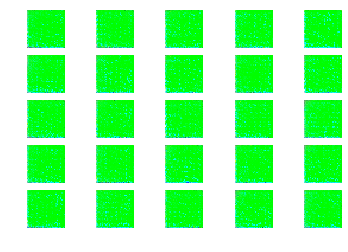

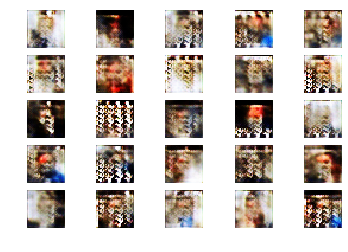

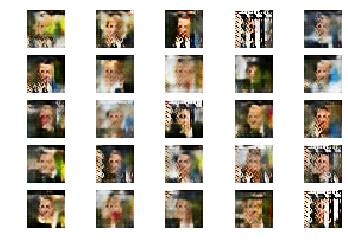

In [5]:
wgan.train(epochs=10000, batch_size=batch_size, sample_interval=1000)

In [ ]:
gan.generator.save('./saved_model/wgangp32_gen_model.h5')
gan.discriminator.save('./saved_model/wgangp32_critic_model.h5')
# gan.combined.save('./saved_model/dcgan_wloss4_combined.h5')

In [20]:
for layer in wgan.critic.layers[1].layers:
    print(layer.name)

conv2d_34
leaky_re_lu_61
conv2d_35
leaky_re_lu_62
conv2d_36
leaky_re_lu_63
conv2d_37
leaky_re_lu_64
conv2d_38
leaky_re_lu_65
conv2d_39
leaky_re_lu_66
conv2d_40
leaky_re_lu_67
conv2d_41
leaky_re_lu_68
conv2d_42
leaky_re_lu_69
conv2d_43
leaky_re_lu_70
conv2d_44
flatten_4


In [ ]:
range(int(math.log(self.img_rows / self.input_rows, 2)))

In [33]:
list = [i for i in range(1, int(math.log(64 / 4, 2)) * 2, 2)]
print(list)

[1, 3, 5, 7]


In [34]:
list = [-i for i in range(int(math.log(64 / 4, 2)) * 2, 0, -2)]
print(list)

[-8, -6, -4, -2]


In [ ]:
[i for i in range(1, int(math.log(self.img_rows / self.input_rows, 2)) * 2, 2)]
[-i for i in range(int(math.log(self.img_rows / self.input_rows, 2)) * 2, 0, -2)]